In [518]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy
from scipy import stats
from datetime import date
import matplotlib
import matplotlib.ticker as mticker
import json
import folium

In [519]:
df_rent = pd.read_csv('Zip_ZORI_AllHomesPlusMultifamily_SSA.csv') # import rent data

In [595]:
df_noise = pd.read_csv('311_Noise_Complaints.csv', dtype={'Incident Zip': str}, low_memory=False) # import 311 noise data

In [596]:
df_noise = df_noise.drop(['Unique Key', 'Closed Date', 'Agency', 'Agency Name', 'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2', 'Intersection Street 1', 'Intersection Street 2', 'Address Type', 'Landmark', 'Facility Type', 'Status', 'Due Date', 'Resolution Description', 'Resolution Action Updated Date', 'Community Board', 'X Coordinate (State Plane)', 'Y Coordinate (State Plane)', 'Park Facility Name', 'Park Borough', 'Vehicle Type', 'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name', 'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment', 'Latitude', 'Longitude', 'Location'], axis=1) # remove extra information

In [633]:
df_noise['Created Date'] = pd.to_datetime(df_noise['Created Date']).dt.to_period('M') # convert Created date to datetime format

In [ ]:
df_noise = df_noise.sort_values(by='Created Date') # sort by incident date

In [21]:
df_zips_list = pd.DataFrame(df_noise['Incident Zip'].value_counts()) # identify all zips in dataset
df_zips_list = df_zips_list.index.values.tolist() # create list from zips
zips_list = sorted(df_zips_list) # sort zip
zips_list.remove('0') # remove random zips
zips_list.remove('00083') # remove random zips

In [22]:
df_months_list = pd.DataFrame(df_noise['Created Date'].value_counts()) # identify dates
df_months_list = df_months_list.sort_index()
months_list = df_months_list.index.values.tolist()
months_list = [date_obj.strftime('%Y-%m') for date_obj in months_list]

In [520]:
df_rent = df_rent.drop(['RegionID', 'SizeRank', 'MsaName'], axis=1) # get rid of extra information

In [24]:
df_noise_zip_month = pd.DataFrame() # create empty data frame

In [25]:
for i in range(len(zips_list)): # create rows for zip codes in blank dataframe
    new_row = {'Zip Codes': zips_list[i]}
    df_noise_zip_month = df_noise_zip_month.append(new_row, ignore_index=True) # add new row for each zip

In [26]:
df_noise_zip_month = df_noise_zip_month.set_index('Zip Codes') # make zip codes the index

In [27]:
NaN = np.nan

for i in range(len(months_list)): # create columns for dates in blank dataframe
    new_column = months_list[i] # set column name
    df_noise_zip_month[new_column] = NaN # create column, fill with NaN values

In [28]:
def zip_month_incident_calc(): # calculate incidents per zip code per month and populate in dataframe
    for i in range (len(months_list)):  # iterate through all month-years  

        months_list_index = i # set to current month-year

        for i in range(len(zips_list)): # iterate through all zip codes for a given month-year

            #zips_list_index = i # set to current zip
            row = zips_list[i] # name of row in which to put data 
            column = months_list[months_list_index] # name of column in which to put data

            df_noise_zip_month.at[row, column] = len(df_noise.loc[(df_noise['Created Date'] == months_list[months_list_index]) & (df_noise['Incident Zip'] == zips_list[i])]) # calculate the number of incidents in this zip code for this month and place it in the correct column and row

In [29]:
zip_month_incident_calc() # run calculation

In [43]:
#########df_noise_zip_month.to_csv(r'noise_zip_month_calculated_1.csv') # save file as csv

In [ ]:
#### CORRELATIONS BY MONTH #### VVVV

In [521]:
#df_noise_zip_month = pd.read_csv('noise_zip_month_calculated_1.csv') # read in saved file in case of oops

In [522]:
df_rent.drop(df_rent.iloc[:, 74:90], inplace=True, axis=1) # drop everything after 2019-12 [74:89]

In [523]:
df_noise_zip_month.drop(df_noise_zip_month.iloc[:, 74:90], inplace=True, axis=1) # drop everything after 2019-12 [75:90]

In [524]:
#df_noise_zip_month.index.name = 'Zip Codes' # move index of zips to a column and rename
#df_noise_zip_month.reset_index(inplace=True) # create new index

In [525]:
df_rent = df_rent.rename(columns={"RegionName": "Zip Codes"}) # rename RegionName column to Zip Codes

In [526]:
df_noise_zip_month = df_noise_zip_month.loc[df_noise_zip_month['Zip Codes'].isin(df_rent['Zip Codes'])] # get rid of zips not present in rent dataframe

In [527]:
df_rent = df_rent.loc[df_rent['Zip Codes'].isin(df_noise_zip_month['Zip Codes'])] # get rid of zips not present in rent dataframe

In [528]:
df_noise_zip_month = df_noise_zip_month.set_index('Zip Codes')

In [529]:
#df_noise_zip_month = df_noise_zip_month.reset_index() # reset index

In [530]:
df_noise_zip_month = df_noise_zip_month.T # tranpose columns to rows

In [531]:
df_noise_zip_month.columns = df_noise_zip_month.columns.map(str) # change column names to str

In [532]:
df_rent = df_rent.sort_values(by=['Zip Codes']) # sort by zip

In [533]:
df_rent = df_rent.set_index('Zip Codes') # set index to Zip Codes

In [534]:
#df_rent = df_rent.reset_index() # reset index

In [535]:
df_rent = df_rent.T # transpose columns to rows

In [536]:
df_rent.columns = df_rent.columns.map(str) # change column names to str

In [537]:
#df_noise_zip_month_t = df_noise_zip_month.T

In [538]:
#df_noise_zip_month_t.drop(df_noise_zip_month_t.iloc[:, '2020-1':'2021-5'], inplace=True, axis=1) # drop data after 2019-12

In [539]:
df_rent = df_rent.fillna(method="bfill") # fill empty values with last month's value

In [540]:
def run_correlations():
    for i in range (len(list(df_rent))):
        zip_code = df_rent.columns[i]
        #contingency = pd.crosstab(df_noise_zip_month[zip_code],df_rent[zip_code]) # compute contingency table
        #scipy.stats.chi2_contingency(contingency) # perform the test
        #c, p, dof, expected = chi2_contingency(contingency)
        corr = stats.pearsonr(df_noise_zip_month[zip_code], df_rent[zip_code])
        #df_correlations.at['p', zip_code] = p
        df_correlations.at['p', zip_code] = corr[1]

In [541]:
df_correlations = df_rent # create new dataframe with zips as columns

In [542]:
df_correlations = df_correlations[0:0] # erase all data

In [543]:
df_correlations = df_correlations.append(pd.Series(name='p', dtype=float)) # create a row with name p

In [544]:
# trim data to before pandemic rent dip (up to 2019-12)

In [545]:
run_correlations() # run correlations

In [546]:
df_correlations = df_correlations.T # transpose

In [547]:
df_correlations = df_correlations.loc[df_correlations['p'] < .05] # eliminate all p values about .05

In [548]:
pd.set_option('max_columns', None) # show all columns

In [626]:
# df_correlations # show significant correlations

In [550]:
### plotting ###

In [552]:
## prepare rent data for plotting ##

In [553]:
df_rent_copy = df_rent.copy()

In [554]:
df_rent_copy.index = pd.to_datetime(df_rent_copy.index) #.to_period('M')

In [555]:
df_rent_copy = df_rent_copy.reset_index() # reset index

In [556]:
df_rent_copy = df_rent_copy.rename(columns={"index": "Dates"}) # rename RegionName column to Zip Codes

In [557]:
df_rent_copy['date_ordinal'] = pd.to_datetime(df_rent_copy['Dates']).apply(lambda date: date.toordinal())

In [558]:
## prepare noise data for plotting ##

In [559]:
df_noise_zip_month_copy = df_noise_zip_month.copy()

In [560]:
df_noise_zip_month_copy.index = pd.to_datetime(df_noise_zip_month_copy.index) #.to_period('M')

In [561]:
df_noise_zip_month_copy = df_noise_zip_month_copy.reset_index() # reset index

In [562]:
df_noise_zip_month_copy = df_noise_zip_month_copy.rename(columns={"index": "Dates"}) # rename index column to Dates

In [563]:
df_noise_zip_month_copy['date_ordinal'] = pd.to_datetime(df_noise_zip_month_copy['Dates']).apply(lambda date: date.toordinal())

In [564]:
p_values = df_correlations.T # set up for grabbin p values for each map

In [624]:
def month_plot_correlations(zip_code):
    fig, ax = matplotlib.pyplot.subplots()

    sns.regplot(x="date_ordinal", y=zip_code, data=df_rent_copy, color='#ED6A5A', label='Rent ($)').set_title(zip_code);

    ax.set_xlabel('Date')
    ax.set_ylabel('Noise Incidents (#)')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(new_labels)
    matplotlib.pyplot.xticks(rotation = 45)

    ax2 = ax.twinx()
    sns.regplot(x="date_ordinal", y=zip_code, data=df_noise_zip_month_copy, color='#5CA4A9', label='Noise Incidents (#)');

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Rent ($)')
    new_labels = [date.fromordinal(int(item)) for item in ax2.get_xticks()]
    ticks_loc = ax2.get_xticks().tolist()
    ax2.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax2.set_xticklabels(new_labels)
    matplotlib.pyplot.xticks(rotation = 45)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, .9))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    
    ax.text(0.02, 0.98, "p = " + str(p_values[zip_code].values), ha="left", va="top", transform=ax.transAxes)
    
    plt.savefig('month_output_' + zip_code + '.png')

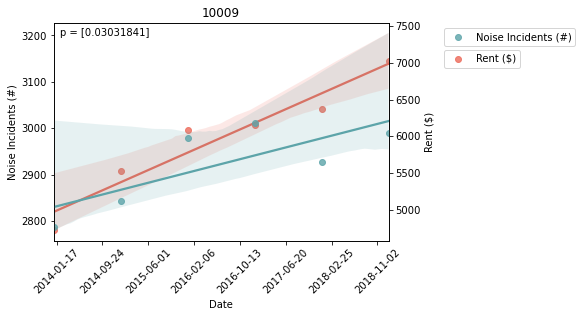

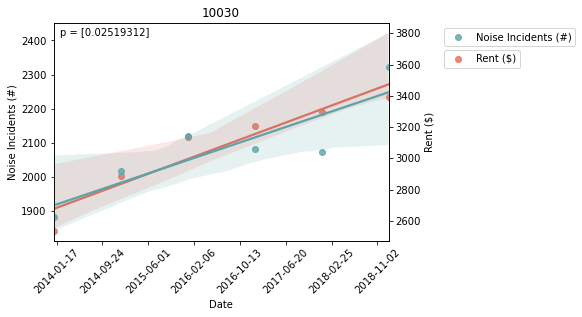

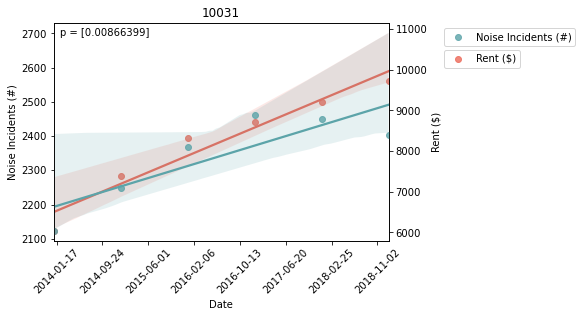

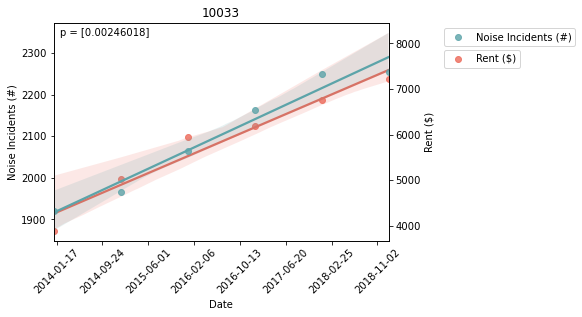

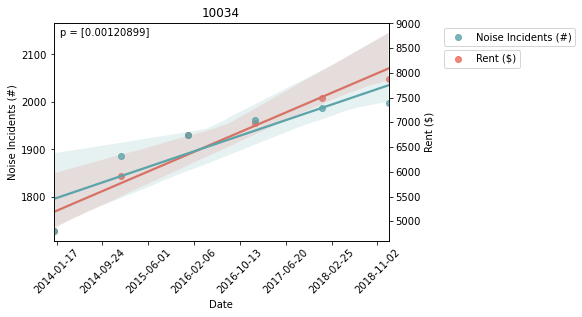

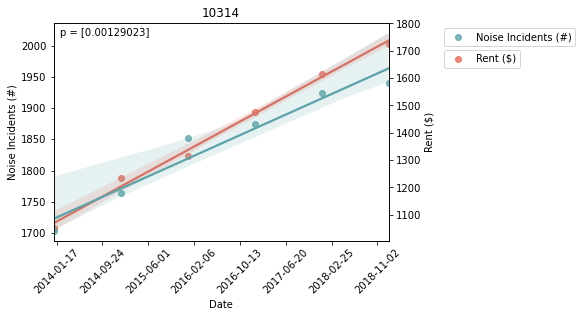

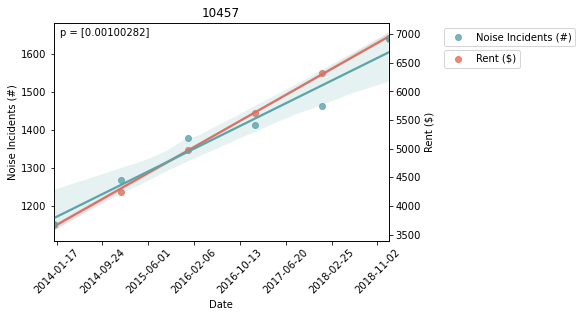

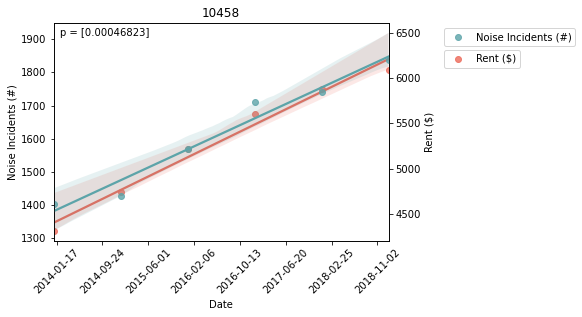

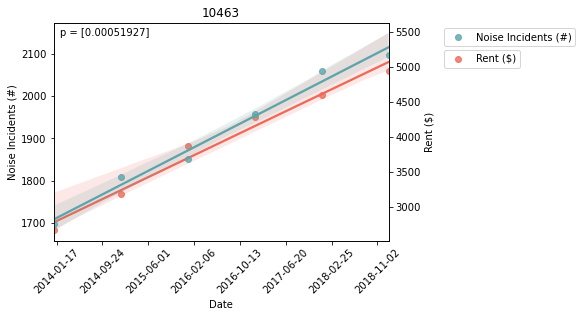

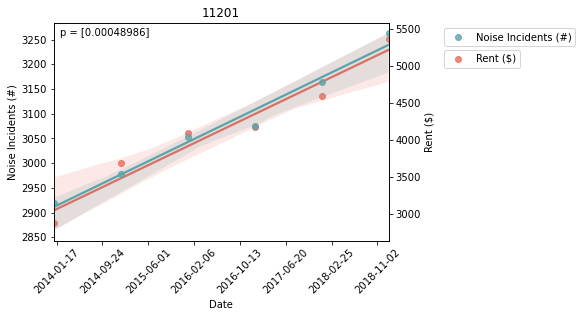

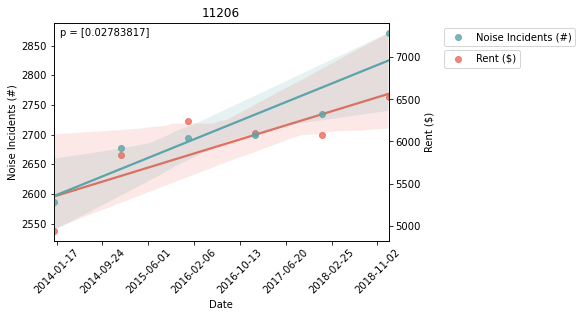

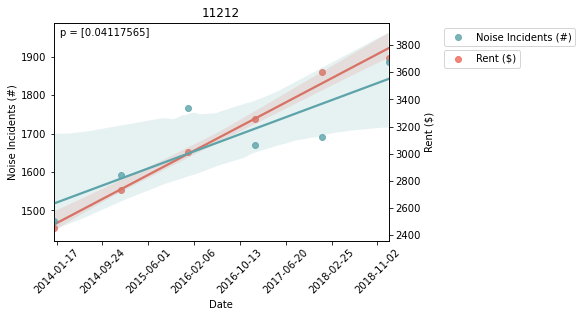

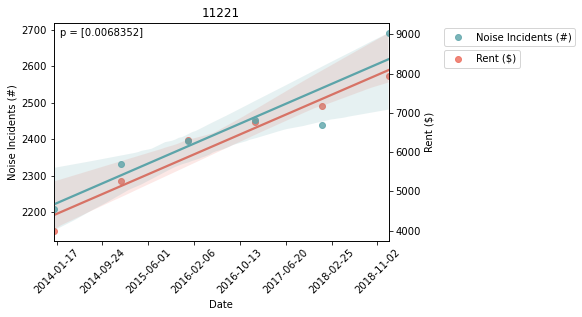

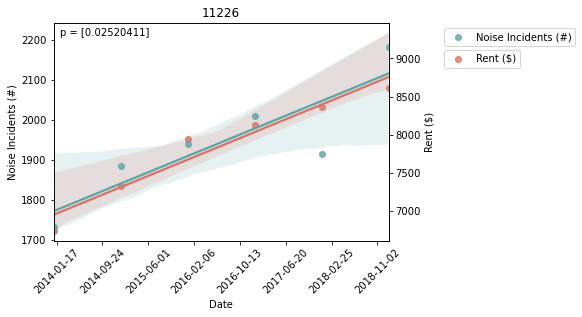

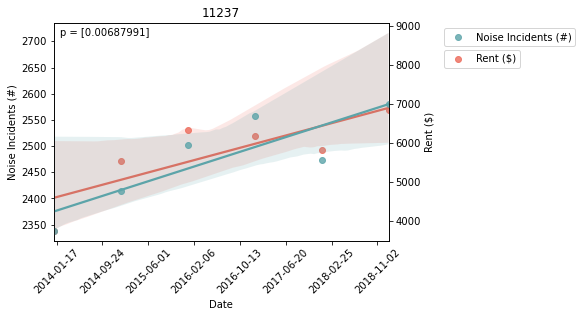

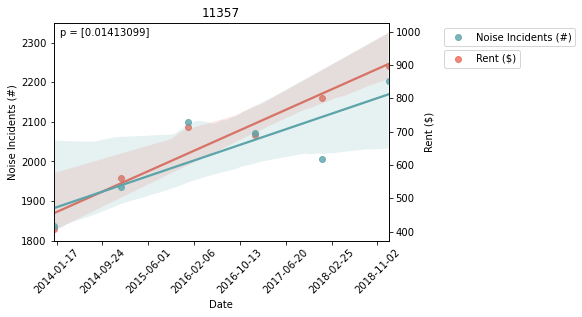

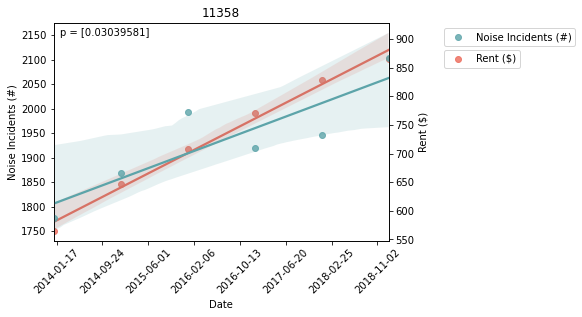

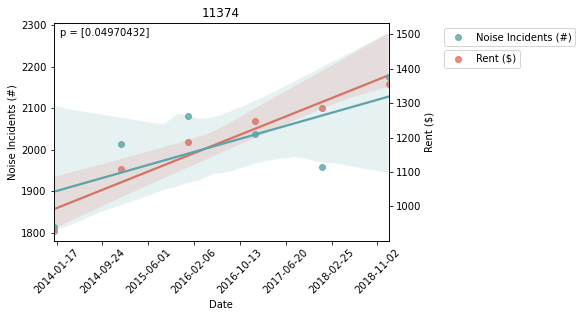

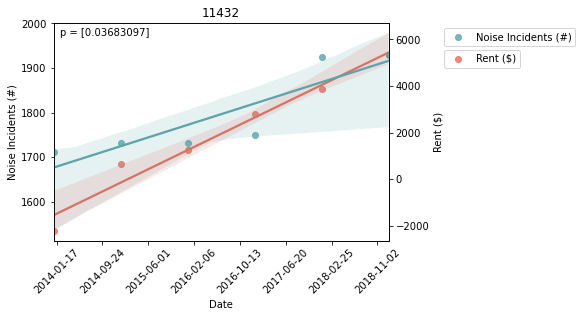

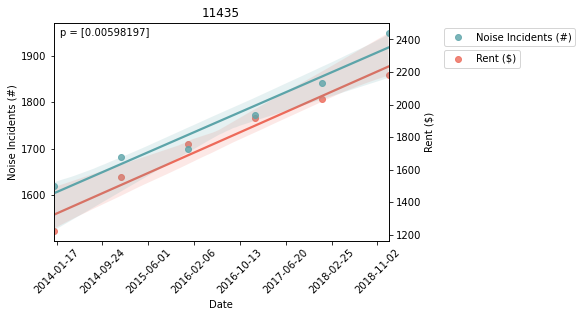

In [625]:
corr_zip_list = list(df_correlations.index) # map correlations and generate plots

for i in range (len(corr_zip_list)):
    zip_codes = list(df_correlations.index)
    the_zip = zip_codes[i]
    month_plot_correlations(the_zip)

In [ ]:
### mapping ###

In [567]:
df_zips_for_map_month = df_correlations

In [568]:
df_zips_for_map_month = df_zips_for_map_month.reset_index() # reset index

In [569]:
df_zips_for_map_month = df_zips_for_map_month.rename(columns={"index": "Zip Code"}) # rename RegionName column to Zip Codes

In [570]:
# load GeoJSON
with open('zip_code_040114.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

# remove ZIP codes not in our dataset
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(df_zips_for_map_month['Zip Code'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("month-updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

2669036

In [572]:
# table = main table/data frame we read from (pandas DataFrame)
# zips = column name where ZIP codes are (string)
# mapped_feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map legend (string)

def month_create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    nyc_geo = r'month-updated-file.json'
    # initiating a Folium map with NYC's longitude and latitude
    m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = nyc_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.ZIPCODE',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' value'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = 'month_' + mapped_feature + '_map.html')

In [574]:
month_create_map(df_zips_for_map_month, 'Zip Code', 'p')

/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [ ]:
#### CORRELATIONS BY YEAR #### VVVV

In [578]:
df_noise_zip_month_add = df_noise_zip_month.T # transpose dataframe

In [579]:
def noise_to_years(year): # add # of noise complaints from months into to years columns
    
    dates_list = list(df_noise_zip_month_add)
    wanted = year

    # using startswith
    result = list(filter(lambda x: x.startswith(wanted), dates_list))
    
    df_noise_zip_month_add[year] = df_noise_zip_month_add[result].sum(axis=1)

In [580]:
years_list = ['2014', '2015', '2016', '2017', '2018', '2019'] # data years

In [581]:
for i in range(len(years_list)): # run noise complaint sum for selected years
    year = years_list[i]
    noise_to_years(year)

In [582]:
df_noise_zip_month_add = df_noise_zip_month_add[years_list] # get rid of month columns

In [583]:
df_noise_zip_month_add = df_noise_zip_month_add.T # transpose dataframe back

In [584]:
df_rent_mean = df_rent.T # transpose dataframe

In [585]:
def rent_to_years(year): # average rent from months into to years columns
    
    dates_list = list(df_rent_mean)
    wanted = year

    # using startswith
    result = list(filter(lambda x: x.startswith(wanted), dates_list))
    
    df_rent_mean[year] = df_rent_mean[result].mean(axis=1)

In [586]:
for i in range(len(years_list)): # run rent mean for selected years
    year = years_list[i]
    rent_to_years(year)

In [587]:
df_rent_mean = df_rent_mean[years_list] # get rid of month columns

In [588]:
df_rent_mean = df_rent_mean.T # transpose dataframe back

In [589]:
df_rent = df_rent_mean # substitute means for individual month values

In [590]:
df_noise_zip_month = df_noise_zip_month_add # substitutes sums for individual noise reports

In [591]:
df_correlations = df_rent # create new dataframe with zips as columns

In [592]:
df_correlations = df_correlations[0:0] # erase all data

In [593]:
df_correlations = df_correlations.append(pd.Series(name='p', dtype=float)) # create a row with name p

In [594]:
run_correlations() # run correlations

In [595]:
df_correlations = df_correlations.T # transpose

In [596]:
df_correlations = df_correlations.loc[df_correlations['p'] < .05] # eliminate all p values about .05

In [597]:
pd.set_option('max_columns', None) # show all columns

In [623]:
# df_correlations # show significant correlations

In [ ]:
### plotting ###

In [599]:
## prepare rent data for plotting ##

In [600]:
df_rent_copy = df_rent.copy() # create copy of df.rent

In [601]:
df_rent_copy.index = pd.to_datetime(df_rent_copy.index) # index to dateteim format

In [602]:
df_rent_copy = df_rent_copy.reset_index() # reset index

In [603]:
df_rent_copy = df_rent_copy.rename(columns={"index": "Dates"}) # rename index column to Dates

In [604]:
df_rent_copy['date_ordinal'] = pd.to_datetime(df_rent_copy['Dates']).apply(lambda date: date.toordinal()) # convert datetime values to ordinal for x-axis

In [605]:
## prepare noise data for plotting ##

In [606]:
df_noise_zip_month_copy = df_noise_zip_month.copy() # create copy of de_noise_zip_month

In [607]:
df_noise_zip_month_copy.index = pd.to_datetime(df_noise_zip_month_copy.index) # index to dateteim format

In [608]:
df_noise_zip_month_copy = df_noise_zip_month_copy.reset_index() # reset index

In [609]:
df_noise_zip_month_copy = df_noise_zip_month_copy.rename(columns={"index": "Dates"}) # rename index column to Dates

In [610]:
df_noise_zip_month_copy['date_ordinal'] = pd.to_datetime(df_noise_zip_month_copy['Dates']).apply(lambda date: date.toordinal()) # convert datetime values to ordinal for x-axis

In [611]:
p_values = df_correlations.T # new df for p values

In [612]:
def year_plot_correlations(zip_code): # create plot for zip code vs rent price by year
    fig, ax = matplotlib.pyplot.subplots()

    sns.regplot(x="date_ordinal", y=zip_code, data=df_rent_copy, color='#ED6A5A', label='Rent ($)').set_title(zip_code);

    ax.set_xlabel('Date')
    ax.set_ylabel('Noise Incidents (#)')
    new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(new_labels)
    matplotlib.pyplot.xticks(rotation = 45)

    ax2 = ax.twinx()
    sns.regplot(x="date_ordinal", y=zip_code, data=df_noise_zip_month_copy, color='#5CA4A9', label='Noise Incidents (#)');

    ax2.set_xlabel('Date')
    ax2.set_ylabel('Rent ($)')
    new_labels = [date.fromordinal(int(item)) for item in ax2.get_xticks()]
    ticks_loc = ax2.get_xticks().tolist()
    ax2.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax2.set_xticklabels(new_labels)
    matplotlib.pyplot.xticks(rotation = 45)
    
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, .9)) # legend for date
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 1)) # legend for noise complaints
    
    ax.text(0.02, 0.98, "p = " + str(p_values[zip_code].values), ha="left", va="top", transform=ax.transAxes) # include p value
    
    plt.savefig('year_output_' + zip_code + '.png') # save plot as

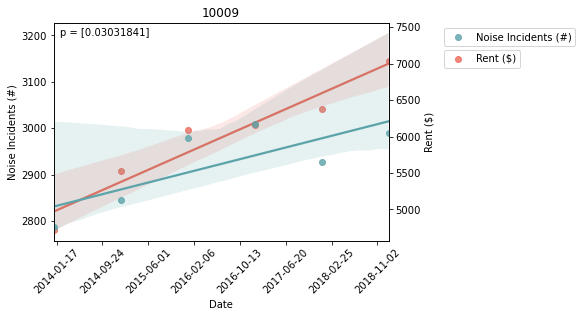

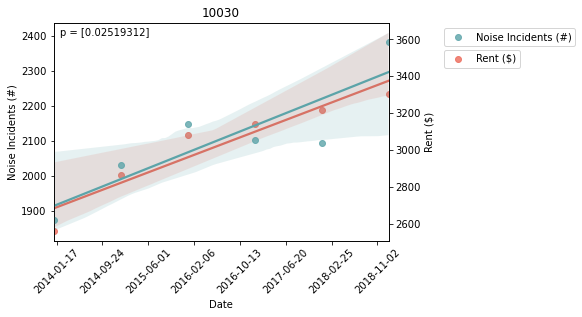

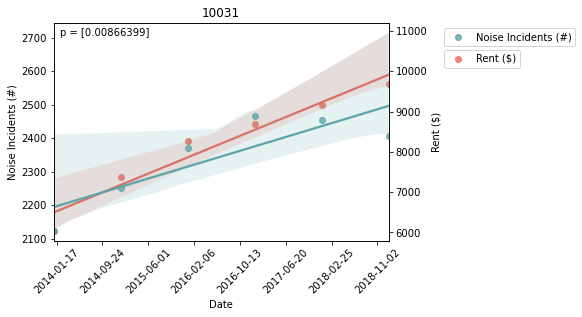

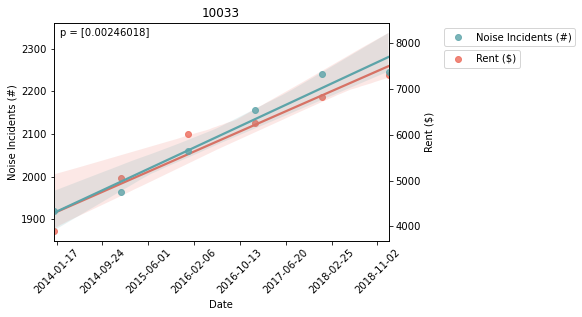

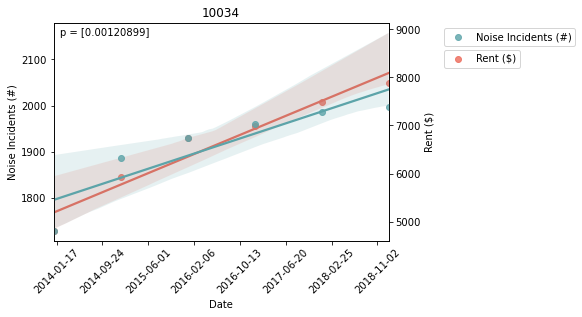

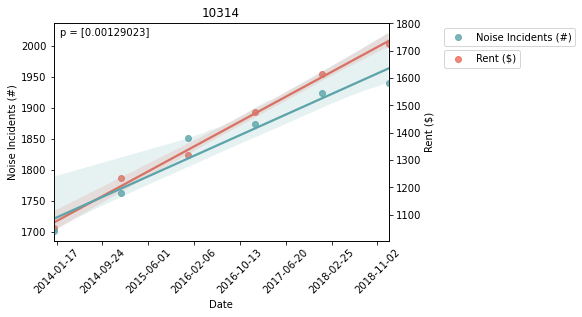

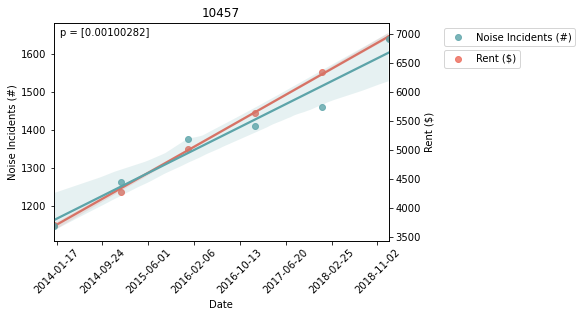

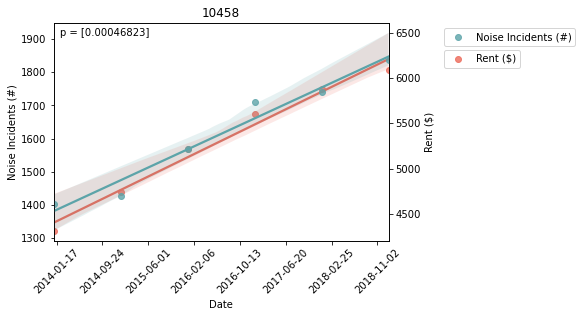

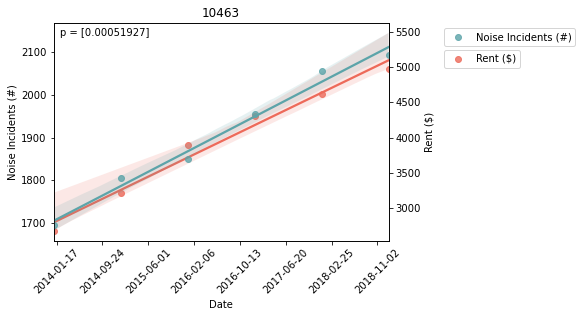

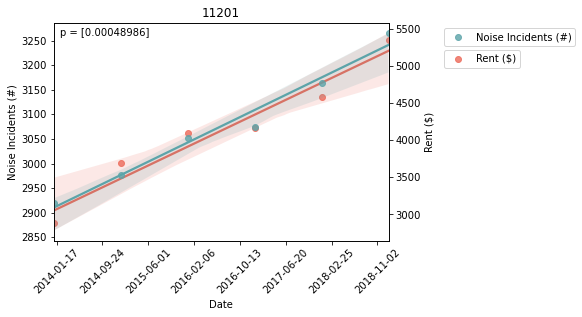

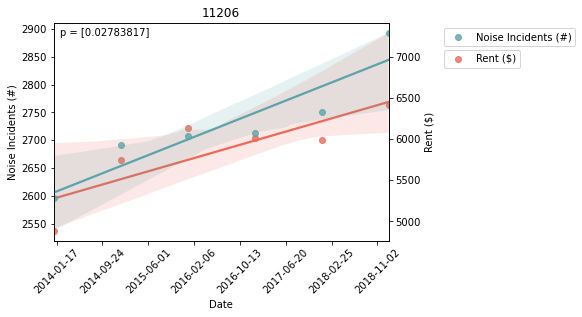

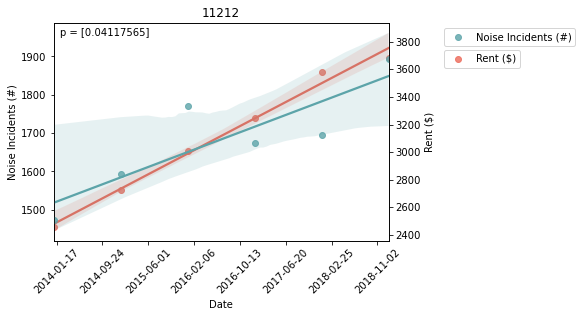

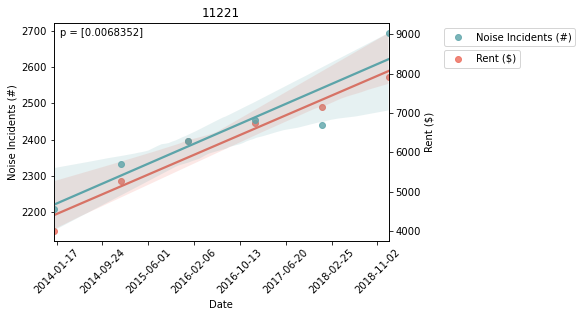

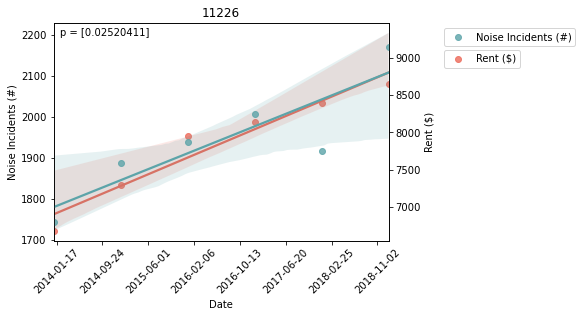

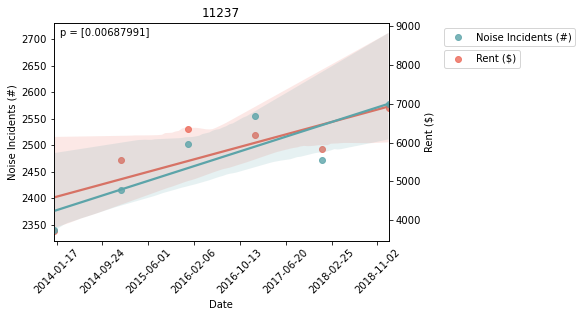

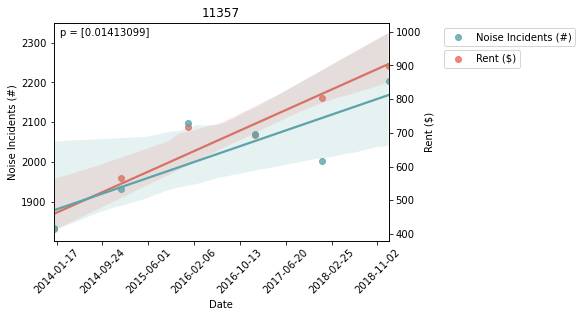

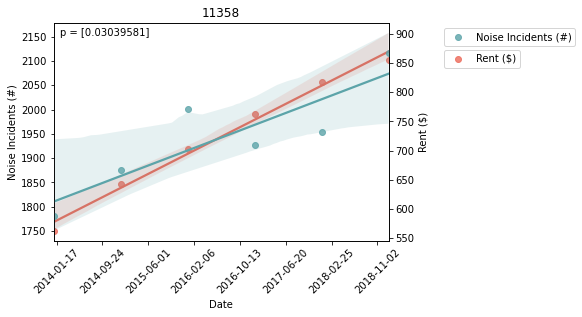

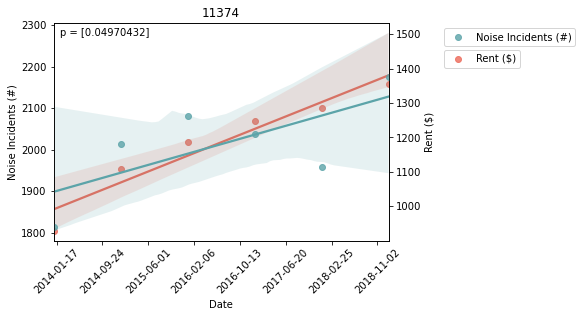

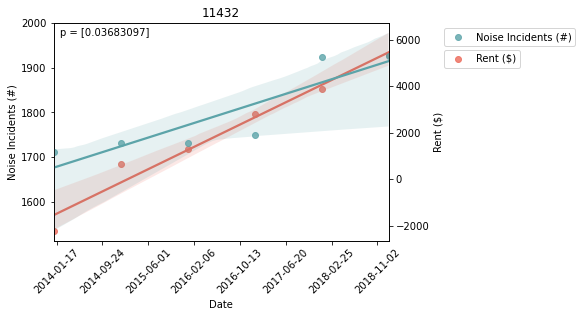

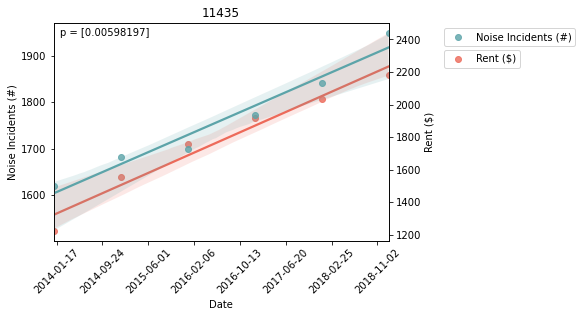

In [613]:
corr_zip_list = list(df_correlations.index) # map correlations and generate plots

for i in range (len(corr_zip_list)):
    zip_codes = list(df_correlations.index)
    the_zip = zip_codes[i]
    year_plot_correlations(the_zip)

In [ ]:
### mapping ###

In [615]:
df_zips_for_map = df_correlations # new df for map, only significant zips

In [616]:
df_zips_for_map = df_zips_for_map.reset_index() # reset index

In [617]:
df_zips_for_map = df_zips_for_map.rename(columns={"index": "Zip Code"}) # rename index column to Zip Code

In [619]:
# load GeoJSON
with open('zip_code_040114.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

# remove ZIP codes not in our dataset
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['ZIPCODE'] in list(df_zips_for_map['Zip Code'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("year-updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

1747896

In [621]:
# table = main table/data frame we read from (pandas DataFrame)
# zips = column name where ZIP codes are (string)
# mapped_feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map legend (string)

def year_create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    nyc_geo = r'year-updated-file.json'
    # initiating a Folium map with NYC's longitude and latitude
    m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = nyc_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.ZIPCODE',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' value'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = 'year_'+ mapped_feature + '_map.html')

In [622]:
year_create_map(df_zips_for_map, 'Zip Code', 'p') # generate map

/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(
